In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from tqdm.notebook import tqdm

In [25]:
import re

In [26]:
with open('/content/irish-lyrics-eof.txt','r') as f:
  text=f.read().splitlines()

In [27]:
# Converting to lower and removing the punctuations and whitespaces
cleaned_text = []
for lines in text:
  lines = re.sub('[^a-zA-Z]', ' ',lines)
  lines = lines.lower()
  lines = lines.strip()
  cleaned_text.append(lines)

In [28]:
# Creating a dictionary of all words

# Creating a list of all words
all_words = []
for line in cleaned_text:
  for word in line.split():
    all_words.append(word)
  
# Removing the duplicate words using set
all_words = set(all_words)

# Creating a dictionary of token index mapping
token2idx = {}
for i,word in enumerate(all_words):
  token2idx[word] = i

# Adding a special token for unseen words
token2idx['UNK'] = max(token2idx.values()) + 1

# Soring the dictionary based on keys
token2idx = {item:val for item,val in sorted(token2idx.items())}

# Creating a dictionary of index token mapping
idx2token = {idx:token for token,idx in token2idx.items()}

# Checking the vocab size
vocab_size = len(token2idx)

In [29]:
# Converting the words in to sequence of numbers
def get_sequence(token2idx,line):
  int_seq = [token2idx[word] if word in token2idx.keys() else token2idx['UNK'] for word in line ]
  return int_seq

In [30]:
def get_max_len():
  max = 0
  for line in cleaned_text:
    line = line.split()
    len_line = len(line)
    if len_line>max:
      max = len_line
  return max

max_length = get_max_len()
max_length

16

In [31]:
# Converting all the sequence to same length (Padding)
def pad_sequence(sequence,max_len=30,padding='pre'):
  seq = np.zeros(max_len,dtype=int)
  len_seq = min(len(sequence),max_len)
  if padding == 'pre':
    seq[-len_seq:] = sequence[:len_seq]
  elif padding == 'post':
    seq[:len_seq] = seq[:len_seq]
  return seq

In [32]:
# Creating ngram tokens of words for inputs
n_gram_tokens = []
for line in cleaned_text:
  line = line.split()
  for i in range(1,len(line)):
    n_gram_tokens.append(line[:i+1])


# Converting tokens to index
sequences = []
for token in n_gram_tokens:
  seq = get_sequence(token2idx,token)
  sequences.append(seq)

In [33]:
# Padding the sequneces
padded_sequence = []
for sequence in sequences:
  pad_seq = pad_sequence(sequence,max_len=max_length)
  padded_sequence.append(pad_seq)

In [34]:
# Creating inputs 
inputs = []
for i in padded_sequence:
  inputs.append(i[:-1])
  
# Converting list to array
inputs = np.array(inputs)

# Converting to torch tensor
inputs = torch.LongTensor(inputs)

In [35]:
# Creating target
target = []
for i in padded_sequence:
  target.append(i[-1])
  
# Converting list to array
target = np.array(target)

# Converting to torch tensor
target = torch.LongTensor(target)

In [36]:
# Creating the dataset
dataset = TensorDataset(inputs,target)

# Creating the dataloader
train_loader = DataLoader(dataset,batch_size=128,shuffle=True,num_workers=3,pin_memory=True)

In [37]:
# Selecting a gpu device
def get_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

device = get_device()
device

device(type='cuda')

In [38]:
# Defining a simple LSTM model
class text_generator(nn.Module):

  def __init__(self):
    super().__init__()
    self.embedding = nn.Embedding(vocab_size,100)
    self.lstm = nn.LSTM(input_size=100,hidden_size=128,num_layers=2,batch_first=True,dropout=0.2)
    self.linear = nn.Linear(128,vocab_size)

  def forward(self,xb):
    out = self.embedding(xb)
    out,(ht,ct) = self.lstm(out)
    out = ht[-1]
    out = self.linear(out)
    return out

In [39]:
model = text_generator()
model

text_generator(
  (embedding): Embedding(2693, 100)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True, dropout=0.2)
  (linear): Linear(in_features=128, out_features=2693, bias=True)
)

In [40]:
model = model.to(device)

In [41]:
# Function to train the model
def fit(num_epochs):
  
  # Defining an optimizer
  optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
  losses = []
  model.train()
  # Training for given no of epochs
  for epoch in range(num_epochs):
   
    batch_loss = []
    for input,target in tqdm(train_loader):
      
      input = input.to(device)
      target = target.to(device)
      out = model(input)
      loss = F.cross_entropy(out,target)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      
      batch_loss.append(loss)

    eph_loss = torch.stack(batch_loss).mean()
    losses.append(eph_loss.item())
    print("epoch: {}, train_loss: {}".format(epoch+1,eph_loss.item()))
  
  return losses

In [42]:
history = fit(150)


epoch: 1, train_loss: 6.8944196701049805



epoch: 2, train_loss: 6.435909271240234



epoch: 3, train_loss: 6.36439323425293



epoch: 4, train_loss: 6.262310028076172



epoch: 5, train_loss: 6.129634857177734



epoch: 6, train_loss: 6.00098180770874



epoch: 7, train_loss: 5.883500099182129



epoch: 8, train_loss: 5.763390064239502



epoch: 9, train_loss: 5.644976615905762



epoch: 10, train_loss: 5.524455547332764



epoch: 11, train_loss: 5.424800872802734



epoch: 12, train_loss: 5.303652763366699



epoch: 13, train_loss: 5.202377796173096



epoch: 14, train_loss: 5.08623743057251



epoch: 15, train_loss: 4.986977577209473



epoch: 16, train_loss: 4.887312412261963



epoch: 17, train_loss: 4.772157669067383



epoch: 18, train_loss: 4.689130783081055



epoch: 19, train_loss: 4.591407299041748



epoch: 20, train_loss: 4.487381935119629



epoch: 21, train_loss: 4.3887529373168945



epoch: 22, train_loss: 4.292740821838379



epoch: 23, train_loss: 4.200535297393799



epoch: 24, train_loss: 4.11273717880249



epoch: 25, train_loss: 4.021407604217529



epoch: 26, train_loss: 3.9264514446258545



epoch: 27, train_loss: 3.8370070457458496



epoch: 28, train_loss: 3.7397704124450684



epoch: 29, train_loss: 3.658742666244507



epoch: 30, train_loss: 3.577404260635376



epoch: 31, train_loss: 3.4854605197906494



epoch: 32, train_loss: 3.40055513381958



epoch: 33, train_loss: 3.320361375808716



epoch: 34, train_loss: 3.249297857284546



epoch: 35, train_loss: 3.157865285873413



epoch: 36, train_loss: 3.0851798057556152



epoch: 37, train_loss: 2.9968080520629883



epoch: 38, train_loss: 2.9216692447662354



epoch: 39, train_loss: 2.8630764484405518



epoch: 40, train_loss: 2.7885544300079346



epoch: 41, train_loss: 2.7266454696655273



epoch: 42, train_loss: 2.645662307739258



epoch: 43, train_loss: 2.5839321613311768



epoch: 44, train_loss: 2.516230583190918



epoch: 45, train_loss: 2.4515771865844727



epoch: 46, train_loss: 2.392127513885498



epoch: 47, train_loss: 2.3429036140441895



epoch: 48, train_loss: 2.271761178970337



epoch: 49, train_loss: 2.2260658740997314



epoch: 50, train_loss: 2.1762492656707764



epoch: 51, train_loss: 2.116713523864746



epoch: 52, train_loss: 2.070326089859009



epoch: 53, train_loss: 2.025205612182617



epoch: 54, train_loss: 1.9712798595428467



epoch: 55, train_loss: 1.9260427951812744



epoch: 56, train_loss: 1.877543330192566



epoch: 57, train_loss: 1.8385812044143677



epoch: 58, train_loss: 1.7952110767364502



epoch: 59, train_loss: 1.7574868202209473



epoch: 60, train_loss: 1.7200913429260254



epoch: 61, train_loss: 1.6866823434829712



epoch: 62, train_loss: 1.6451419591903687



epoch: 63, train_loss: 1.6120470762252808



epoch: 64, train_loss: 1.5738624334335327



epoch: 65, train_loss: 1.544251561164856



epoch: 66, train_loss: 1.5053386688232422



epoch: 67, train_loss: 1.4862909317016602



epoch: 68, train_loss: 1.4475268125534058



epoch: 69, train_loss: 1.4112485647201538



epoch: 70, train_loss: 1.3945817947387695



epoch: 71, train_loss: 1.3665343523025513



epoch: 72, train_loss: 1.3440600633621216



epoch: 73, train_loss: 1.3084944486618042



epoch: 74, train_loss: 1.2856231927871704



epoch: 75, train_loss: 1.2634392976760864



epoch: 76, train_loss: 1.239410161972046



epoch: 77, train_loss: 1.213861107826233



epoch: 78, train_loss: 1.191999912261963



epoch: 79, train_loss: 1.175223708152771



epoch: 80, train_loss: 1.1564385890960693



epoch: 81, train_loss: 1.1374585628509521



epoch: 82, train_loss: 1.1154991388320923



epoch: 83, train_loss: 1.0934231281280518



epoch: 84, train_loss: 1.0732091665267944



epoch: 85, train_loss: 1.0617097616195679



epoch: 86, train_loss: 1.0514253377914429



epoch: 87, train_loss: 1.036001443862915



epoch: 88, train_loss: 1.0203710794448853



epoch: 89, train_loss: 1.0015349388122559



epoch: 90, train_loss: 0.9903196096420288



epoch: 91, train_loss: 0.9676868319511414



epoch: 92, train_loss: 0.9549242854118347



epoch: 93, train_loss: 0.9388805627822876



epoch: 94, train_loss: 0.9343889951705933



epoch: 95, train_loss: 0.9147576689720154



epoch: 96, train_loss: 0.9095655083656311



epoch: 97, train_loss: 0.8848385214805603



epoch: 98, train_loss: 0.8806525468826294



epoch: 99, train_loss: 0.860088050365448



epoch: 100, train_loss: 0.8593779802322388



epoch: 101, train_loss: 0.8478018045425415



epoch: 102, train_loss: 0.8329129219055176



epoch: 103, train_loss: 0.8176064491271973



epoch: 104, train_loss: 0.8119978308677673



epoch: 105, train_loss: 0.8027815222740173



epoch: 106, train_loss: 0.7969983816146851



epoch: 107, train_loss: 0.7923672795295715



epoch: 108, train_loss: 0.7793365120887756



epoch: 109, train_loss: 0.770743727684021



epoch: 110, train_loss: 0.7620078325271606



epoch: 111, train_loss: 0.7568987607955933



epoch: 112, train_loss: 0.7514199018478394



epoch: 113, train_loss: 0.7417053580284119



epoch: 114, train_loss: 0.7352745532989502



epoch: 115, train_loss: 0.7285962700843811



epoch: 116, train_loss: 0.7272726893424988



epoch: 117, train_loss: 0.7133838534355164



epoch: 118, train_loss: 0.7096410393714905



epoch: 119, train_loss: 0.7096385359764099



epoch: 120, train_loss: 0.7006548047065735



epoch: 121, train_loss: 0.6838358044624329



epoch: 122, train_loss: 0.6866459250450134



epoch: 123, train_loss: 0.6826934814453125



epoch: 124, train_loss: 0.6806601285934448



epoch: 125, train_loss: 0.6713438034057617



epoch: 126, train_loss: 0.6667528748512268



epoch: 127, train_loss: 0.6555185914039612



epoch: 128, train_loss: 0.6599436402320862



epoch: 129, train_loss: 0.662016749382019



epoch: 130, train_loss: 0.6460195779800415



epoch: 131, train_loss: 0.6427623629570007



epoch: 132, train_loss: 0.6290550231933594



epoch: 133, train_loss: 0.6391940116882324



epoch: 134, train_loss: 0.6292072534561157



epoch: 135, train_loss: 0.6245424747467041



epoch: 136, train_loss: 0.6206742525100708



epoch: 137, train_loss: 0.6147946119308472



epoch: 138, train_loss: 0.6180907487869263



epoch: 139, train_loss: 0.6133927702903748



epoch: 140, train_loss: 0.6049599051475525



epoch: 141, train_loss: 0.5968758463859558



epoch: 142, train_loss: 0.607473611831665



epoch: 143, train_loss: 0.5968095660209656



epoch: 144, train_loss: 0.589918851852417



epoch: 145, train_loss: 0.5818906426429749



epoch: 146, train_loss: 0.58903968334198



epoch: 147, train_loss: 0.5783238410949707



epoch: 148, train_loss: 0.5838501453399658



epoch: 149, train_loss: 0.5840005278587341



epoch: 150, train_loss: 0.5855462551116943


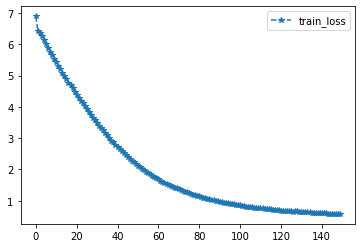

In [43]:
# Plotting the losses
train_loss = history
plt.plot(train_loss,label='train_loss',linestyle='--',marker='*')
plt.legend()
plt.show()

In [49]:
# Prediction of new words
num_words = 30
pr_text = 'I love my love and well he knows'
for i in range(num_words):
  pr_text = pr_text.lower()
  token_list = get_sequence(token2idx,pr_text)
  padded_list = torch.LongTensor([pad_sequence(token_list,max_len=max_length-1,padding='pre')])
  padded_list = padded_list.to(device)
  with torch.no_grad():
    predicted = model(padded_list)
  predicted = torch.argmax(predicted).item()
  pr_word = ''
  for id,token in idx2token.items():
    if id == predicted:
      pr_word = token
      break
  pr_text = pr_text + ' ' +pr_word

print(pr_text)

i love my love and well he knows doves james she james she james doves doves she piper she fairest she piper she james fairest halfway she the james doves james doves she james covered she james the
